# TCS Stock Data anlysis and Prediction

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings("ignore")

In [3]:
hist_data= pd.read_csv(r"F:\Vaishnavi\practiced\vs code\Unified Mentor\TCS stock Data\TCS_stock_history.csv")
hist_data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2002-08-12,28.794172,29.742206,28.794172,29.519140,212976,0.0,0.0
1,2002-08-13,29.556316,30.030333,28.905705,29.119476,153576,0.0,0.0
2,2002-08-14,29.184536,29.184536,26.563503,27.111877,822776,0.0,0.0
3,2002-08-15,27.111877,27.111877,27.111877,27.111877,0,0.0,0.0
4,2002-08-16,26.972458,28.255089,26.582090,27.046812,811856,0.0,0.0


In [4]:
hist_data.dtypes

Date             object
Open            float64
High            float64
Low             float64
Close           float64
Volume            int64
Dividends       float64
Stock Splits    float64
dtype: object

In [5]:
hist_data['Date'] = pd.to_datetime(hist_data['Date'])
hist_data = hist_data.sort_values('Date').reset_index(drop=True)              # ensuring data is ordered and index too for future slicing,rolling calculation

In [6]:
hist_data.isnull().sum()

Date            0
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

In [7]:
hist_data.duplicated().sum()

np.int64(0)

# EDA

In [8]:
hist_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4463 entries, 0 to 4462
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          4463 non-null   datetime64[ns]
 1   Open          4463 non-null   float64       
 2   High          4463 non-null   float64       
 3   Low           4463 non-null   float64       
 4   Close         4463 non-null   float64       
 5   Volume        4463 non-null   int64         
 6   Dividends     4463 non-null   float64       
 7   Stock Splits  4463 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 279.1 KB


In [9]:
hist_data.describe()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,4463,4463.000000,4463.000000,4463.000000,4463.000000,4.463000e+03,4463.000000,4463.000000
mean,2012-08-23 19:22:31.109119488,866.936239,876.675013,856.653850,866.537398,3.537876e+06,0.071533,0.001344
min,2002-08-12 00:00:00,24.146938,27.102587,24.146938,26.377609,0.000000e+00,0.000000,0.000000
25%,2008-02-14 12:00:00,188.951782,191.571816,185.979417,188.594620,1.860959e+06,0.000000,0.000000
50%,2012-09-04 00:00:00,530.907530,534.751639,525.616849,529.713257,2.757742e+06,0.000000,0.000000
75%,2017-03-22 12:00:00,1156.462421,1165.815854,1143.622800,1154.784851,4.278625e+06,0.000000,0.000000
max,2021-09-30 00:00:00,3930.000000,3981.750000,3892.100098,3954.550049,8.806715e+07,40.000000,2.000000
std,NaN,829.905368,838.267104,821.233477,829.611313,3.273531e+06,0.965401,0.051842


- Opening stock price is expand in range 180- 1156
- For many days opening price can be the highest price of stock for that day
- Most days have moderate trading
- Outlier does exist in volumn that indicate to festive season or some such event occurances
- open,high,low and cloed prices are higly related 
- Dividends and Stock Splits are mostly zero with only few spikes, rarely impact daily prediction and can be ignored for basic analysis

In [10]:
hist_data1 = hist_data.drop(columns=['Dividends','Stock Splits'])


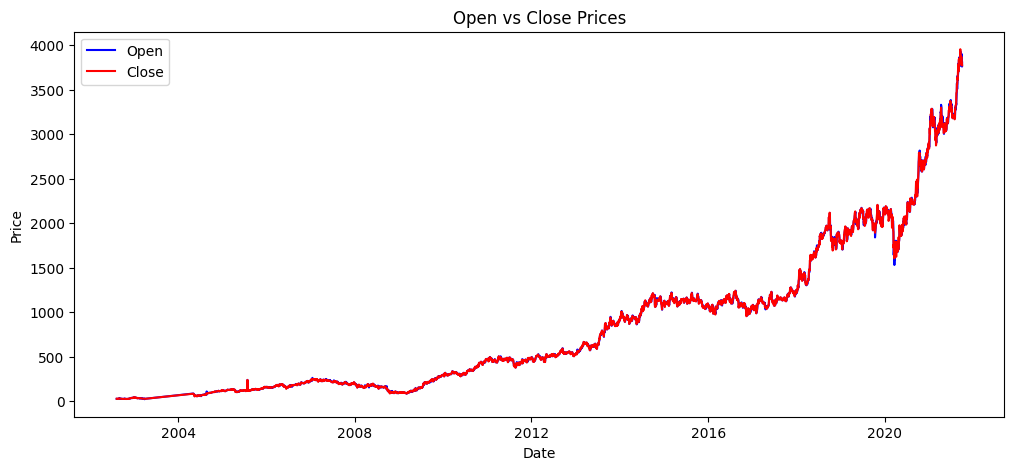

In [11]:
# price trend over time



plt.figure(figsize=(12,5))
sns.lineplot(x='Date', y='Open', data=hist_data1, color='blue', label='Open')
sns.lineplot(x='Date', y='Close', data=hist_data1, color='red', label='Close')
plt.title('Open vs Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()



- Almost every opening price and closing price is equal. Open price cn predict close price of stock.

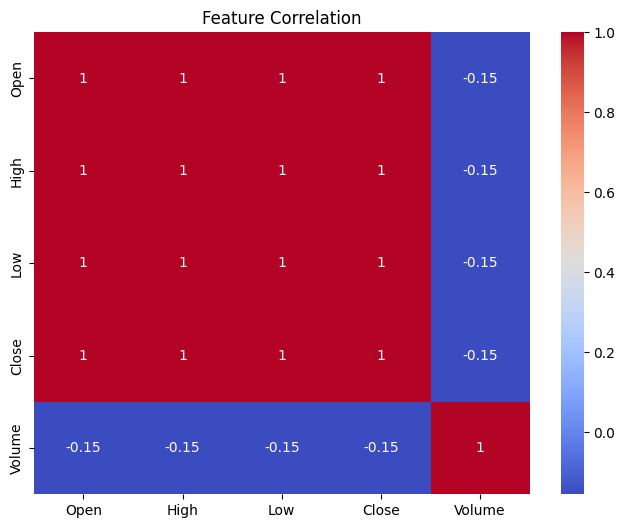

In [12]:

plt.figure(figsize=(8,6))
sns.heatmap(hist_data1[['Open','High','Low','Close','Volume']].corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation')
plt.show()


- price related feature shows high correlation
- volumn do not have major effect on stock price

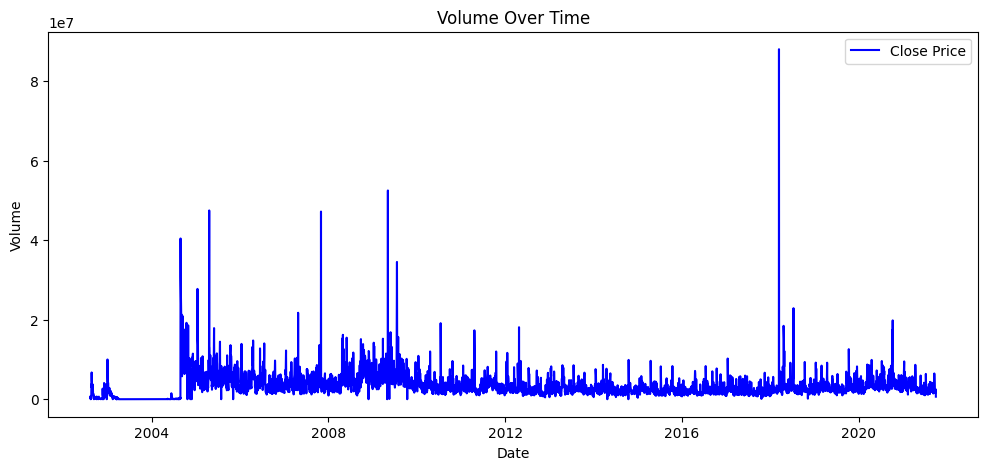

In [13]:

plt.figure(figsize=(12,5))

sns.lineplot(data=hist_data1, x='Date', y='Volume', color='blue', label='Close Price')
plt.title('Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()


- volumn are irregular and varies over time.
- spiks in volumn likely to occur due to important market events

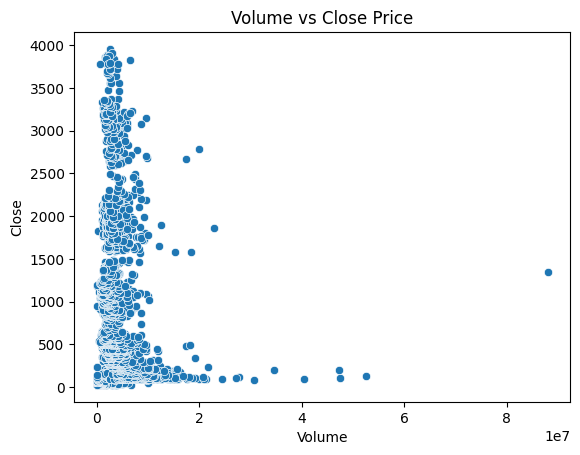

In [14]:
sns.scatterplot(x='Volume', y='Close', data=hist_data1)
plt.title('Volume vs Close Price')
plt.show()


- High volumn occurs at both high and low closed price. Few outlier exist at high volumne. 
- Volumn alone has no major effect on close price

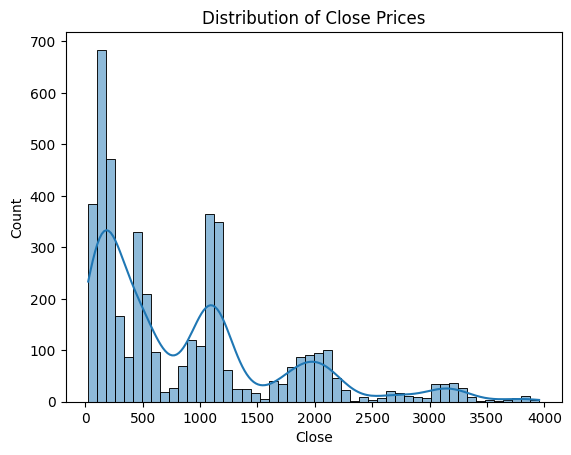

In [15]:
sns.histplot(hist_data1['Close'], bins=50, kde=True)
plt.title('Distribution of Close Prices')
plt.show()


- It shows righ side skewness. Most of data point are accumlated towards left side(low close price). While some outliers exist in right side(high close price)
- price behaviour is not a stationary and have changed to different ranges of values

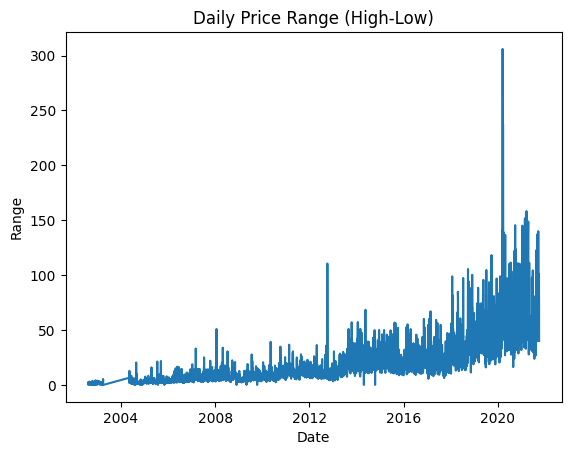

In [16]:
hist_data1['Range'] = hist_data1['High'] - hist_data1['Low']
sns.lineplot(x='Date', y='Range', data=hist_data1)
plt.title('Daily Price Range (High-Low)')
plt.show()


- Daily price range become more volatile(sudden chage/unpredictable) over time. 
- After 2016 grapgh shows more spikes indicating high uncertainty of intraday stock prices, this could be due to different market events or market instability

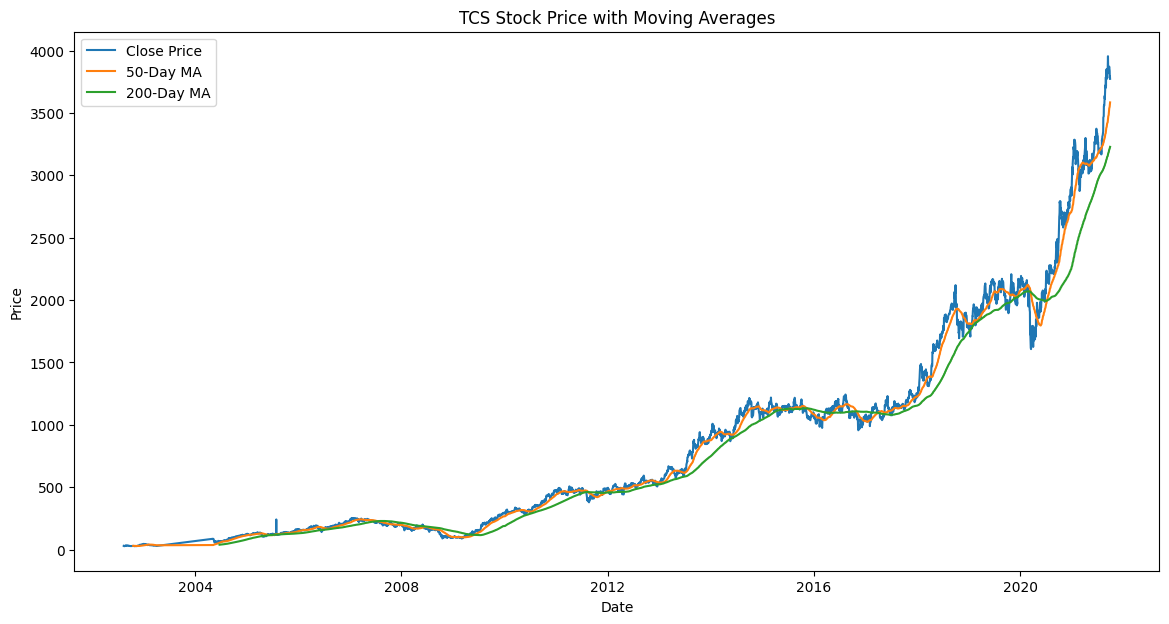

In [17]:
# Calculating 50-day and 200-day moving averages
hist_data1['MA50'] = hist_data1['Close'].rolling(window=50).mean()
hist_data1['MA200'] = hist_data1['Close'].rolling(window=200).mean()
hist_data1

plt.figure(figsize=(14, 7))
plt.plot(hist_data1['Date'], hist_data1['Close'], label='Close Price')
plt.plot(hist_data1['Date'], hist_data1['MA50'], label='50-Day MA')
plt.plot(hist_data1['Date'], hist_data1['MA200'], label='200-Day MA')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('TCS Stock Price with Moving Averages')
plt.legend()
plt.show()

EDA Findings:
- Stock shows increased volatality over a time
- Price related feature are highly corelated. Need to performe feature selection.
- Volumn have weak corelation with close price but it is helpful to understand the market events for a short time
- opening price can be used to predict cole price of stock

# Feature Engineering

- Even though in normal ML case feature engineering should be done after split
- As this is a time series data feature like month, day of week are derived from Date column
- Roliing means and Prev_Close are time related feature calculated on past data so it is safe to do it before split

In [18]:
hist_data1['Month'] = hist_data1['Date'].dt.month 
hist_data1['Day_of_Week'] = hist_data1['Date'].dt.dayofweek
hist_data1.dropna(inplace=True)

In [19]:
# hist_data = hist_data.sort_values('Date').reset_index(drop=True)         ... ensuring data is ordered with new correct indexing for slicing, rolling calculation

# columns already added

#data['MA_50'] = data['Close'].rolling(window=50).mean().shift(1)
#data['MA_200'] = data['Close'].rolling(window=200).mean().shift(1)


In [20]:
print(hist_data1.columns)


Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Range', 'MA50',
       'MA200', 'Month', 'Day_of_Week'],
      dtype='object')


In [21]:
hist_data1['Prev_Close'] = hist_data1['Close'].shift(1)               # Prev_Close = previous days close price 
hist_data1 = hist_data1.dropna().reset_index(drop=True)               # very first day can not have Prev_Close hence become NaN

In [22]:
hist_data1.head()

,Date,Open,High,Low,Close,Volume,Range,MA50,MA200,Month,Day_of_Week,Prev_Close
0,2004-06-22,65.432855,65.618744,63.573967,63.927155,20064,2.044777,54.208315,38.533714,6,1,65.451401
1,2004-06-23,64.596334,65.061056,61.584935,62.681683,22912,3.476122,54.837176,38.701525,6,2,63.927155
2,2004-06-24,63.192893,64.317518,61.919554,63.722672,21592,2.397964,55.496152,38.884579,6,3,62.681683
3,2004-06-25,63.202185,65.061073,63.202185,63.722672,60280,1.858888,56.147134,39.067632,6,4,63.722672
4,2004-06-28,64.838011,67.849412,64.838011,66.808434,100536,3.011401,56.859832,39.266441,6,0,63.722672


In [23]:
# save file
hist_data1.to_csv("TCS_stock_processed_data.csv", index=False)

# Model Building

In [24]:
X = hist_data1[['Open', 'High', 'Low', 'Volume', 'Range','MA50','MA200','Month','Day_of_Week','Prev_Close' ]]
y = hist_data1['Close']

In [25]:
# Time time-based split

split_index = int(len(X) * 0.8)

X_train = X.iloc[:split_index]
X_test  = X.iloc[split_index:]

y_train = y.iloc[:split_index]
y_test  = y.iloc[split_index:]


In [26]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=10.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, objective='reg:squarederror')
}

# Loop through models
for name, model in models.items():

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Evaluate
    
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    
    print(f"{name} Results --> RMSE: {rmse:.4f}, R²: {r2:.4f}, MAE: {mae:.4f}, MSE: {mse:.4f}, ")


Linear Regression Results --> RMSE: 14.6851, R²: 0.9994, MAE: 10.6184, MSE: 215.6532, 
Ridge Regression Results --> RMSE: 14.6851, R²: 0.9994, MAE: 10.6186, MSE: 215.6528, 
Random Forest Results --> RMSE: 1011.6956, R²: -2.0689, MAE: 830.7168, MSE: 1023528.0728, 
Gradient Boosting Results --> RMSE: 1008.7074, R²: -2.0508, MAE: 827.5728, MSE: 1017490.5731, 
XGBoost Results --> RMSE: 1025.9029, R²: -2.1557, MAE: 847.1527, MSE: 1052476.7903, 


ARRIMA

In [27]:
#!pip install pmdarima  

from pmdarima import auto_arima

hist_data1['Date'] = pd.to_datetime(hist_data1['Date'])
hist_data1.set_index('Date', inplace=True)

ts = hist_data1['Close']  # arrima is univariate need only one series

# auto_arima --> p,d,f
model = auto_arima(ts, 
                   seasonal=False,   # ARIMA (non-seasonal)
                   stepwise=True,    # faster search
                   trace=False)       # prints progress

print(model.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4263
Model:               SARIMAX(5, 2, 0)   Log Likelihood              -18953.472
Date:                Thu, 08 Jan 2026   AIC                          37918.943
Time:                        23:49:37   BIC                          37957.087
Sample:                             0   HQIC                         37932.421
                               - 4263                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8784      0.007   -133.069      0.000      -0.891      -0.865
ar.L2         -0.7352      0.008    -89.301      0.000      -0.751      -0.719
ar.L3         -0.5736      0.010    -58.651      0.0

In [28]:
from statsmodels.tsa.arima.model import ARIMA

train = ts[:-30]
test = ts[-30:]

model = ARIMA(train, order=(5,2,0))
model_fit = model.fit()
pred = model_fit.forecast(steps=30)

rmse1 = np.sqrt(mean_squared_error(test, pred))
mae1 = mean_absolute_error(test, pred)
mse1 = mean_squared_error(test, pred)
r2_1 = r2_score(test, pred)


#print(f"ARIMA RMSE: {rmse:.4f}")
print(f"ARIMA Model Results --> RMSE: {rmse1:.4f}, R²: {r2_1:.4f}, MAE1: {mae:.4f}, MSE1: {mse:.4f}, ")



c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA Model Results --> RMSE: 631.6082, R²: -39.1996, MAE1: 847.1527, MSE1: 1052476.7903, 


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


# Cross Validation

In [29]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
import numpy as np

# Define models to try
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1)  # Example alpha, can tune later
}

# Time-based CV
tscv = TimeSeriesSplit(n_splits=5)

# Loop through models and evaluate
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
    print(f"{name} CV R² scores: {scores}")
    print(f"{name} mean CV R²: {np.mean(scores):.4f}\n")


Linear Regression CV R² scores: [0.99669537 0.99952893 0.99763338 0.99694766 0.99697794]
Linear Regression mean CV R²: 0.9976

Ridge Regression CV R² scores: [0.99669572 0.99952892 0.99763345 0.99694762 0.99697793]
Ridge Regression mean CV R²: 0.9976



# Final Model

- Linear Regression and Ridge model performs almost same.
- Ridge regularization will not make any major change in performance.
- As the features are few and predictive overfitting risk is less. linear regression will be easy and is prefered here

In [30]:
final_model =  LinearRegression()                      # Linear Regression have not parameter to tune
    
final_model.fit(X_train, y_train) 
y_pred = final_model.predict(X_test)

    

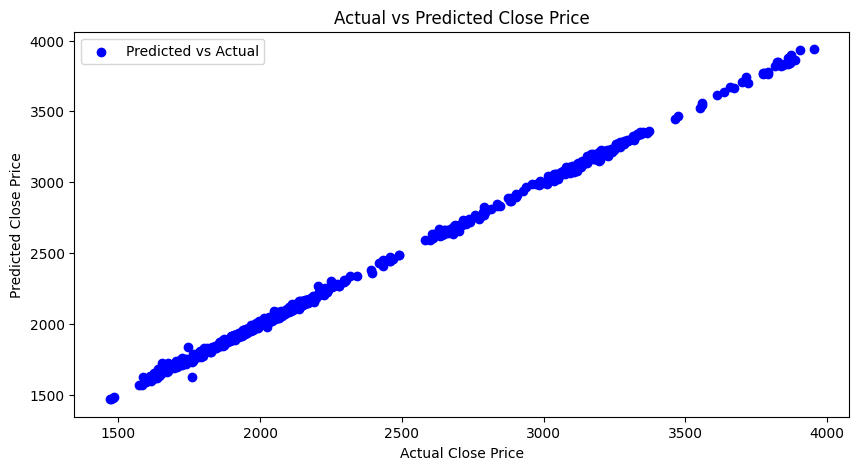

In [31]:


plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, color='blue', label='Predicted vs Actual')

plt.xlabel('Actual Close Price')
plt.ylabel('Predicted Close Price')
plt.title('Actual vs Predicted Close Price')
plt.legend()
plt.show()



In [32]:
#save model 
import pickle
with open('TCS_Stock_Predictor.pkl', 'wb') as file:
    pickle.dump(final_model, file)